In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [6]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [7]:
output_size = y_table.shape[0]

In [8]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
input_shape = x_test_2d_norm[0].shape

In [ ]:
def build_cnn(conv_num=1, fcn_num=1):
    model=Sequential()
    model.add(Conv2D (kernel_size=5, filters=8, strides=(1,1), padding='valid', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv2D (kernel_size=5, filters=8*(2**(i+1)), strides=(1,1), padding='valid', 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))

    model.add(Flatten())
    
    for i in range(fcn_num):
        model.add(Dense( 1024/(2**i), activation='relu' ))
        model.add(Dropout(0.5))
    
    model.add(Dense(output_size, activation='softmax' ))
    return model

In [43]:
# for i in range(1, 5):
#     for j in range(1, 3):
#         print(i, j)
#         model = build_cnn(conv_num=i, fcn_num=j)
#         model.summary()
#         del model

1 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 253, 95, 8)        208       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 127, 48, 8)        0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 48768)             0         
_________________________________________________________________
dense_62 (Dense)             (None, 1024)              49939456  
_________________________________________________________________
dropout_37 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_63 (Dense)             (None, 16)                16400     
Total params: 49,956,064
Trainable params: 49,956,064
Non-trainable params: 0
____________________________________________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 253, 95, 8)        208       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 127, 48, 8)        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 123, 44, 16)       3216      
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 62, 22, 16)        0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 58, 18, 32)        12832     
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 29, 9, 32)         0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 25, 5, 64)         51264     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.3968 - acc: 0.5701
Epoch 00001: val_loss improved from inf to 0.86395, saving model to model/checkpoint/2D_CNN_1_conv_1_fcn_checkpoint/01-0.8639.hdf5
36805/36805 [==============================] - 30s 828us/sample - loss: 1.3963 - acc: 0.5702 - val_loss: 0.8639 - val_acc: 0.7487
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.8523 - acc: 0.7366
Epoch 00002: val_loss improved from 0.86395 to 0.67669, saving model to model/checkpoint/2D_CNN_1_conv_1_fcn_checkpoint/02-0.6767.hdf5
36805/36805 [==============================] - 29s 790us/sample - loss: 0.8523 - acc: 0.7365 - val_loss: 0.6767 - val_acc: 0.8090
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.6517 - acc: 0.7978
Epoch 00003: val_loss improved from 0.67669 to 0.60216, saving model to model/checkpoint/

36800/36805 [============================>.] - ETA: 0s - loss: 0.0579 - acc: 0.9842
Epoch 00027: val_loss did not improve from 0.47989
36805/36805 [==============================] - 28s 769us/sample - loss: 0.0579 - acc: 0.9842 - val_loss: 0.5702 - val_acc: 0.8796
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0545 - acc: 0.9846
Epoch 00028: val_loss did not improve from 0.47989
36805/36805 [==============================] - 28s 772us/sample - loss: 0.0545 - acc: 0.9846 - val_loss: 0.5780 - val_acc: 0.8791
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0592 - acc: 0.9839
Epoch 00029: val_loss did not improve from 0.47989
36805/36805 [==============================] - 28s 774us/sample - loss: 0.0591 - acc: 0.9839 - val_loss: 0.5957 - val_acc: 0.8807
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0583 - acc: 0.9836
Epoch 00030: val_loss did not improve from 0.47989
36805/36805 [==================

Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9912
Epoch 00057: val_loss did not improve from 0.47989
36805/36805 [==============================] - 28s 770us/sample - loss: 0.0349 - acc: 0.9912 - val_loss: 0.6986 - val_acc: 0.8840
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9903
Epoch 00058: val_loss did not improve from 0.47989
36805/36805 [==============================] - 28s 770us/sample - loss: 0.0340 - acc: 0.9903 - val_loss: 0.6740 - val_acc: 0.8877
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9921
Epoch 00059: val_loss did not improve from 0.47989
36805/36805 [==============================] - 28s 770us/sample - loss: 0.0292 - acc: 0.9921 - val_loss: 0.6792 - val_acc: 0.8840
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9917
Epoch 00060: val_loss did not improve from 0.47989
36805/36805 [=====

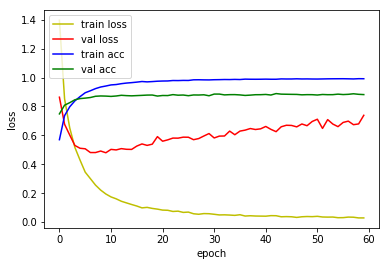

4815/4815 [==============================] - 1s 243us/sample - loss: 0.9692 - acc: 0.8469
Loss: 0.9691994140514579 Accuracy: 0.84693664
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.8487 - acc: 0.4245
Epoch 00001: val_loss improved from inf to 1.09597, saving model to model/checkpoint/2D_CNN_1_conv_2_fcn_checkpoint/01-1.0960.hdf5
36805/36805 [==============================] - 33s 887us/sample - loss: 1.8487 - acc: 0.4245 - val_loss: 1.0960 - val_acc: 0.6893
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.2390 - acc: 0.6138
Epoch 00002: val_loss improved from 1.09597 to 0.82195, saving model to model/checkpoint/2D_CNN_1_conv_2_fcn_checkpoint/02-0.8220.hdf5
36805/36805 [==============================] - 34s 914us/sample - loss: 1.2389 - acc: 0.6139 - val_loss: 0.8220 - val_acc: 0.7610
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9688 - acc: 0.6979
E

Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0989 - acc: 0.9708
Epoch 00027: val_loss did not improve from 0.46762
36805/36805 [==============================] - 33s 909us/sample - loss: 0.0989 - acc: 0.9708 - val_loss: 0.5895 - val_acc: 0.8784
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0995 - acc: 0.9708
Epoch 00028: val_loss did not improve from 0.46762
36805/36805 [==============================] - 33s 908us/sample - loss: 0.0995 - acc: 0.9708 - val_loss: 0.5486 - val_acc: 0.8770
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0930 - acc: 0.9732
Epoch 00029: val_loss did not improve from 0.46762
36805/36805 [==============================] - 33s 909us/sample - loss: 0.0930 - acc: 0.9732 - val_loss: 0.5859 - val_acc: 0.8756
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0879 - acc: 0.9746
Epoch 00030: val_loss did not improve from 0.46762
36805/36805 [=====

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9865
Epoch 00057: val_loss did not improve from 0.46762
36805/36805 [==============================] - 33s 907us/sample - loss: 0.0473 - acc: 0.9866 - val_loss: 0.6417 - val_acc: 0.8849
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0427 - acc: 0.9883
Epoch 00058: val_loss did not improve from 0.46762
36805/36805 [==============================] - 33s 907us/sample - loss: 0.0427 - acc: 0.9883 - val_loss: 0.6677 - val_acc: 0.8831
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0491 - acc: 0.9865
Epoch 00059: val_loss did not improve from 0.46762
36805/36805 [==============================] - 33s 908us/sample - loss: 0.0491 - acc: 0.9865 - val_loss: 0.6657 - val_acc: 0.8810
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9866
Epoch 00060: val_loss did not improve from 0.46762
36805/36805 [=====

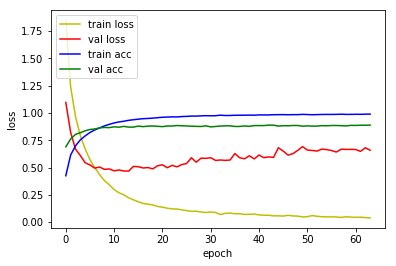

4815/4815 [==============================] - 1s 241us/sample - loss: 0.8137 - acc: 0.8563
Loss: 0.8136908744602065 Accuracy: 0.8562825
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.2945 - acc: 0.6060
Epoch 00001: val_loss improved from inf to 0.72898, saving model to model/checkpoint/2D_CNN_2_conv_1_fcn_checkpoint/01-0.7290.hdf5
36805/36805 [==============================] - 23s 638us/sample - loss: 1.2944 - acc: 0.6060 - val_loss: 0.7290 - val_acc: 0.7997
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.6896 - acc: 0.7884
Epoch 00002: val_loss improved from 0.72898 to 0.52339, saving model to model/checkpoint/2D_CNN_2_conv_1_fcn_checkpoint/02-0.5234.hdf5
36805/36805 [==============================] - 22s 607us/sample - loss: 0.6895 - acc: 0.7885 - val_loss: 0.5234 - val_acc: 0.8579
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.4782 - acc: 0.8514
Ep

36800/36805 [============================>.] - ETA: 0s - loss: 0.0246 - acc: 0.9931
Epoch 00028: val_loss did not improve from 0.35258
36805/36805 [==============================] - 22s 601us/sample - loss: 0.0246 - acc: 0.9931 - val_loss: 0.4402 - val_acc: 0.9182
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0194 - acc: 0.9947
Epoch 00029: val_loss did not improve from 0.35258
36805/36805 [==============================] - 22s 601us/sample - loss: 0.0194 - acc: 0.9947 - val_loss: 0.4524 - val_acc: 0.9168
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9945
Epoch 00030: val_loss did not improve from 0.35258
36805/36805 [==============================] - 22s 601us/sample - loss: 0.0198 - acc: 0.9945 - val_loss: 0.4449 - val_acc: 0.9161
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0195 - acc: 0.9946
Epoch 00031: val_loss did not improve from 0.35258
36805/36805 [==================

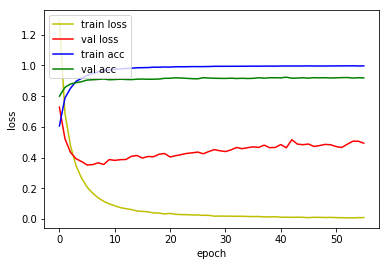

4815/4815 [==============================] - 1s 265us/sample - loss: 0.6375 - acc: 0.8939
Loss: 0.6375311403569155 Accuracy: 0.89387333
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.6349 - acc: 0.4838
Epoch 00001: val_loss improved from inf to 0.86295, saving model to model/checkpoint/2D_CNN_2_conv_2_fcn_checkpoint/01-0.8630.hdf5
36805/36805 [==============================] - 24s 639us/sample - loss: 1.6347 - acc: 0.4838 - val_loss: 0.8630 - val_acc: 0.7393
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9518 - acc: 0.6988
Epoch 00002: val_loss improved from 0.86295 to 0.59088, saving model to model/checkpoint/2D_CNN_2_conv_2_fcn_checkpoint/02-0.5909.hdf5
36805/36805 [==============================] - 22s 607us/sample - loss: 0.9517 - acc: 0.6988 - val_loss: 0.5909 - val_acc: 0.8204
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.6865 - acc: 0.7825
E

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0111 - acc: 0.9970
Epoch 00057: val_loss did not improve from 0.27382
36805/36805 [==============================] - 22s 605us/sample - loss: 0.0111 - acc: 0.9970 - val_loss: 0.4418 - val_acc: 0.9255
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9971
Epoch 00058: val_loss did not improve from 0.27382
36805/36805 [==============================] - 22s 601us/sample - loss: 0.0093 - acc: 0.9971 - val_loss: 0.4395 - val_acc: 0.9285
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9968
Epoch 00059: val_loss did not improve from 0.27382
36805/36805 [==============================] - 22s 604us/sample - loss: 0.0113 - acc: 0.9968 - val_loss: 0.4071 - val_acc: 0.9304
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9971
Epoch 00060: val_loss did not improve from 0.27382
36805/36805 [=====

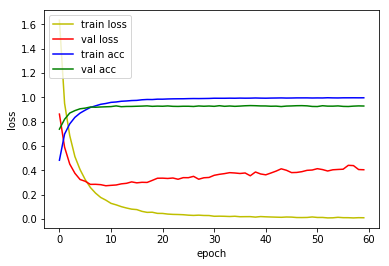

4815/4815 [==============================] - 1s 258us/sample - loss: 0.5414 - acc: 0.9059
Loss: 0.5413688052896322 Accuracy: 0.905919
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.3182 - acc: 0.5930
Epoch 00001: val_loss improved from inf to 0.66652, saving model to model/checkpoint/2D_CNN_3_conv_1_fcn_checkpoint/01-0.6665.hdf5
36805/36805 [==============================] - 20s 552us/sample - loss: 1.3181 - acc: 0.5930 - val_loss: 0.6665 - val_acc: 0.8081
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.6365 - acc: 0.8012
Epoch 00002: val_loss improved from 0.66652 to 0.43344, saving model to model/checkpoint/2D_CNN_3_conv_1_fcn_checkpoint/02-0.4334.hdf5
36805/36805 [==============================] - 19s 514us/sample - loss: 0.6364 - acc: 0.8012 - val_loss: 0.4334 - val_acc: 0.8763
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.4414 - acc: 0.8631
Epo

Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9915
Epoch 00027: val_loss did not improve from 0.24737
36805/36805 [==============================] - 19s 511us/sample - loss: 0.0292 - acc: 0.9915 - val_loss: 0.2931 - val_acc: 0.9401
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9923
Epoch 00028: val_loss did not improve from 0.24737
36805/36805 [==============================] - 19s 514us/sample - loss: 0.0258 - acc: 0.9923 - val_loss: 0.3053 - val_acc: 0.9413
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9920
Epoch 00029: val_loss did not improve from 0.24737
36805/36805 [==============================] - 19s 511us/sample - loss: 0.0264 - acc: 0.9920 - val_loss: 0.2855 - val_acc: 0.9471
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9922
Epoch 00030: val_loss did not improve from 0.24737
36805/36805 [=====

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9976
Epoch 00057: val_loss did not improve from 0.24737
36805/36805 [==============================] - 19s 513us/sample - loss: 0.0091 - acc: 0.9976 - val_loss: 0.3727 - val_acc: 0.9415
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0101 - acc: 0.9972
Epoch 00058: val_loss did not improve from 0.24737
36805/36805 [==============================] - 19s 511us/sample - loss: 0.0101 - acc: 0.9972 - val_loss: 0.3683 - val_acc: 0.9420
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0136 - acc: 0.9962
Epoch 00059: val_loss did not improve from 0.24737
36805/36805 [==============================] - 19s 522us/sample - loss: 0.0136 - acc: 0.9962 - val_loss: 0.3808 - val_acc: 0.9413
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0148 - acc: 0.9961
Epoch 00060: val_loss did not improve from 0.24737
36805/36805 [=====

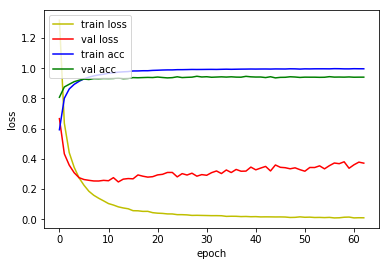

4815/4815 [==============================] - 1s 270us/sample - loss: 0.4568 - acc: 0.9211
Loss: 0.4567836045361533 Accuracy: 0.92107993
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.7199 - acc: 0.4519
Epoch 00001: val_loss improved from inf to 0.92321, saving model to model/checkpoint/2D_CNN_3_conv_2_fcn_checkpoint/01-0.9232.hdf5
36805/36805 [==============================] - 22s 594us/sample - loss: 1.7198 - acc: 0.4520 - val_loss: 0.9232 - val_acc: 0.7186
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9370 - acc: 0.7034
Epoch 00002: val_loss improved from 0.92321 to 0.55870, saving model to model/checkpoint/2D_CNN_3_conv_2_fcn_checkpoint/02-0.5587.hdf5
36805/36805 [==============================] - 24s 645us/sample - loss: 0.9370 - acc: 0.7034 - val_loss: 0.5587 - val_acc: 0.8372
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.6589 - acc: 0.7911
E

Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0150 - acc: 0.9955
Epoch 00056: val_loss did not improve from 0.23589
36805/36805 [==============================] - 24s 644us/sample - loss: 0.0150 - acc: 0.9955 - val_loss: 0.3420 - val_acc: 0.9443
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0142 - acc: 0.9958
Epoch 00057: val_loss did not improve from 0.23589
36805/36805 [==============================] - 24s 647us/sample - loss: 0.0142 - acc: 0.9958 - val_loss: 0.3384 - val_acc: 0.9469
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.9961
Epoch 00058: val_loss did not improve from 0.23589
36805/36805 [==============================] - 24s 646us/sample - loss: 0.0137 - acc: 0.9961 - val_loss: 0.3450 - val_acc: 0.9455
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0152 - acc: 0.9954
Epoch 00059: val_loss did not improve from 0.23589
36805/36805 [=====

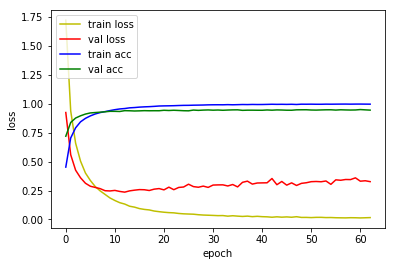

4815/4815 [==============================] - 1s 268us/sample - loss: 0.4365 - acc: 0.9294
Loss: 0.43645365917117085 Accuracy: 0.92938733
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.5487 - acc: 0.5174
Epoch 00001: val_loss improved from inf to 0.90333, saving model to model/checkpoint/2D_CNN_4_conv_1_fcn_checkpoint/01-0.9033.hdf5
36805/36805 [==============================] - 20s 533us/sample - loss: 1.5486 - acc: 0.5174 - val_loss: 0.9033 - val_acc: 0.7303
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.7919 - acc: 0.7552
Epoch 00002: val_loss improved from 0.90333 to 0.53944, saving model to model/checkpoint/2D_CNN_4_conv_1_fcn_checkpoint/02-0.5394.hdf5
36805/36805 [==============================] - 18s 489us/sample - loss: 0.7918 - acc: 0.7553 - val_loss: 0.5394 - val_acc: 0.8481
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.5538 - acc: 0.8295


Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9938
Epoch 00056: val_loss did not improve from 0.22491
36805/36805 [==============================] - 18s 484us/sample - loss: 0.0191 - acc: 0.9938 - val_loss: 0.3347 - val_acc: 0.9490
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0186 - acc: 0.9945
Epoch 00057: val_loss did not improve from 0.22491
36805/36805 [==============================] - 18s 484us/sample - loss: 0.0186 - acc: 0.9945 - val_loss: 0.3458 - val_acc: 0.9462
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9937
Epoch 00058: val_loss did not improve from 0.22491
36805/36805 [==============================] - 18s 484us/sample - loss: 0.0210 - acc: 0.9937 - val_loss: 0.3379 - val_acc: 0.9467
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0203 - acc: 0.9942
Epoch 00059: val_loss did not improve from 0.22491
36805/36805 [=====

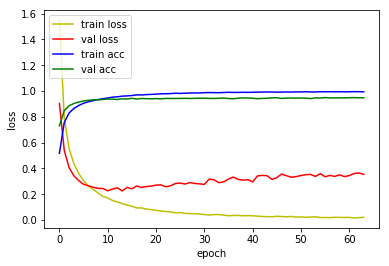

4815/4815 [==============================] - 1s 270us/sample - loss: 0.4546 - acc: 0.9265
Loss: 0.4545511203210681 Accuracy: 0.92647976
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.8127 - acc: 0.4187
Epoch 00001: val_loss improved from inf to 0.96513, saving model to model/checkpoint/2D_CNN_4_conv_2_fcn_checkpoint/01-0.9651.hdf5
36805/36805 [==============================] - 20s 549us/sample - loss: 1.8126 - acc: 0.4187 - val_loss: 0.9651 - val_acc: 0.6990
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9626 - acc: 0.6922
Epoch 00002: val_loss improved from 0.96513 to 0.57160, saving model to model/checkpoint/2D_CNN_4_conv_2_fcn_checkpoint/02-0.5716.hdf5
36805/36805 [==============================] - 18s 486us/sample - loss: 0.9625 - acc: 0.6922 - val_loss: 0.5716 - val_acc: 0.8290
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.6851 - acc: 0.7822
E

Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0736 - acc: 0.9750
Epoch 00026: val_loss did not improve from 0.23682
36805/36805 [==============================] - 18s 490us/sample - loss: 0.0736 - acc: 0.9750 - val_loss: 0.2825 - val_acc: 0.9392
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0786 - acc: 0.9747
Epoch 00027: val_loss did not improve from 0.23682
36805/36805 [==============================] - 18s 489us/sample - loss: 0.0786 - acc: 0.9747 - val_loss: 0.2766 - val_acc: 0.9443
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0676 - acc: 0.9782
Epoch 00028: val_loss did not improve from 0.23682
36805/36805 [==============================] - 18s 489us/sample - loss: 0.0676 - acc: 0.9782 - val_loss: 0.2784 - val_acc: 0.9418
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0649 - acc: 0.9786
Epoch 00029: val_loss did not improve from 0.23682
36805/36805 [=====

Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9922
Epoch 00056: val_loss did not improve from 0.23682
36805/36805 [==============================] - 18s 486us/sample - loss: 0.0269 - acc: 0.9921 - val_loss: 0.3542 - val_acc: 0.9413
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0304 - acc: 0.9907
Epoch 00057: val_loss did not improve from 0.23682
36805/36805 [==============================] - 18s 487us/sample - loss: 0.0304 - acc: 0.9907 - val_loss: 0.3099 - val_acc: 0.9460
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9917
Epoch 00058: val_loss did not improve from 0.23682
36805/36805 [==============================] - 18s 488us/sample - loss: 0.0274 - acc: 0.9917 - val_loss: 0.3497 - val_acc: 0.9422
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9932
Epoch 00059: val_loss did not improve from 0.23682
36805/36805 [=====

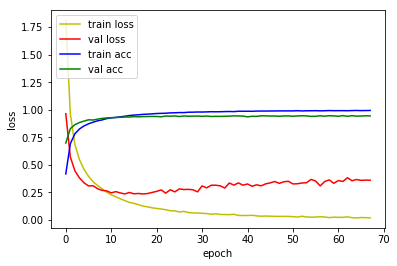

4815/4815 [==============================] - 1s 266us/sample - loss: 0.4964 - acc: 0.9234
Loss: 0.4963619096414561 Accuracy: 0.92336446


In [45]:
for i in range(1, 5):
    for j in range(1, 3):
        model = build_cnn(conv_num=i, fcn_num=j)
#         model.summary()
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])
    
        model_path = 'model/checkpoint/2D_CNN_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        os.makedirs(model_path, exist_ok=True)
        model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
        checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                       verbose=1, save_best_only=True)

        early_stopping = EarlyStopping(monitor='val_loss', patience=50)
        hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=200, 
                         validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                         callbacks = [checkpointer, early_stopping])

        print()
        print('{} Conv {} FCN Model'.format(i, j))
        fig, ax = plt.subplots()
        ax.plot(hist.history['loss'], 'y', label='train loss')
        ax.plot(hist.history['val_loss'], 'r', label='val loss')
        ax.plot(hist.history['acc'], 'b', label='train acc')
        ax.plot(hist.history['val_acc'], 'g', label='val acc')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        plt.show()
        
        png_path = 'visualization/learning_curve/'
        filename = '2D_CNN_{}_conv_{}_fcn'.format(i, j)+'.png'
        os.makedirs(png_path, exist_ok=True)
        fig.savefig(png_path+filename, transparent=True)
        
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
        model = load_model(model_filename)
        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

In [10]:
for i in range(1, 5):
    for j in range(1, 3):
        model_name = '2D_CNN_{}_conv_{}_fcn'.format(i, j)
        print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'
  
        model = load_model(model_filename)
        model.summary()
    
        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

2D_CNN_1_conv_1_fcn Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 253, 95, 8)        208       
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 127, 48, 8)        0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 48768)             0         
_________________________________________________________________
dense_84 (Dense)             (None, 1024)              49939456  
_________________________________________________________________
dropout_50 (Dropout)         (None, 1024)              0         
_____________

4815/4815 [==============================] - 1s 273us/sample - loss: 0.3271 - acc: 0.9119
Loss: 0.3270782148479054 Accuracy: 0.9119418

2D_CNN_3_conv_2_fcn Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 253, 95, 8)        208       
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 127, 48, 8)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 123, 44, 16)       3216      
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 62, 22, 16)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 58, 18, 32)        12832     
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 29, 9, 32)

In [47]:
def build_cnn_bn(conv_num=1, fcn_num=1):
    model=Sequential()
    model.add(Conv2D (kernel_size=5, filters=8, strides=(1,1), padding='valid', 
                      activation='relu', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv2D (kernel_size=5, filters=8*(2**(i+1)), strides=(1,1), padding='valid', 
                          activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))

    model.add(Flatten())
    
    for i in range(fcn_num):
        model.add(Dense( 1024/(2**i), activation='relu' ))
        model.add(Dropout(0.5))
    
    model.add(Dense(output_size, activation='softmax' ))
    return model

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.8650 - acc: 0.4699
Epoch 00001: val_loss improved from inf to 1.09670, saving model to model/checkpoint/2D_CNN_BN_1_conv_1_fcn_checkpoint/01-1.0967.hdf5
36805/36805 [==============================] - 34s 930us/sample - loss: 1.8649 - acc: 0.4699 - val_loss: 1.0967 - val_acc: 0.6867
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.1393 - acc: 0.6530
Epoch 00002: val_loss improved from 1.09670 to 0.83002, saving model to model/checkpoint/2D_CNN_BN_1_conv_1_fcn_checkpoint/02-0.8300.hdf5
36805/36805 [==============================] - 33s 899us/sample - loss: 1.1394 - acc: 0.6529 - val_loss: 0.8300 - val_acc: 0.7640
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.8915 - acc: 0.7240
Epoch 00003: val_loss improved from 0.83002 to 0.73647, saving model to model/checkpoint/2D_CNN_BN_1_conv_1_fcn_checkpoint/03-0.736

Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1275 - acc: 0.9623
Epoch 00028: val_loss did not improve from 0.58786
36805/36805 [==============================] - 32s 878us/sample - loss: 0.1275 - acc: 0.9623 - val_loss: 0.7476 - val_acc: 0.8621
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1217 - acc: 0.9636
Epoch 00029: val_loss did not improve from 0.58786
36805/36805 [==============================] - 32s 876us/sample - loss: 0.1217 - acc: 0.9636 - val_loss: 0.7264 - val_acc: 0.8614
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1192 - acc: 0.9637
Epoch 00030: val_loss did not improve from 0.58786
36805/36805 [==============================] - 32s 876us/sample - loss: 0.1192 - acc: 0.9637 - val_loss: 0.7656 - val_acc: 0.8507
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1124 - acc: 0.9658
Epoch 00031: val_loss did not improve from 0.58786
36805/36805 [=====

Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0635 - acc: 0.9810
Epoch 00058: val_loss did not improve from 0.58786
36805/36805 [==============================] - 32s 875us/sample - loss: 0.0636 - acc: 0.9810 - val_loss: 0.9036 - val_acc: 0.8572
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0641 - acc: 0.9814
Epoch 00059: val_loss did not improve from 0.58786
36805/36805 [==============================] - 32s 875us/sample - loss: 0.0641 - acc: 0.9814 - val_loss: 0.9047 - val_acc: 0.8598
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0645 - acc: 0.9810
Epoch 00060: val_loss did not improve from 0.58786
36805/36805 [==============================] - 32s 875us/sample - loss: 0.0645 - acc: 0.9810 - val_loss: 0.8714 - val_acc: 0.8616
Epoch 61/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0582 - acc: 0.9828
Epoch 00061: val_loss did not improve from 0.58786
36805/36805 [=====

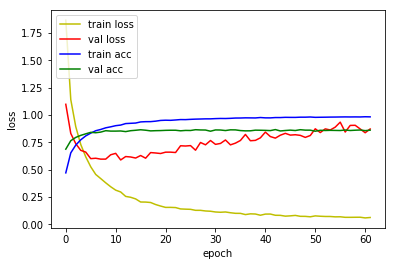

4815/4815 [==============================] - 1s 280us/sample - loss: 1.0721 - acc: 0.8332
Loss: 1.0721348436450662 Accuracy: 0.8332295
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.4174 - acc: 0.2780
Epoch 00001: val_loss improved from inf to 1.59380, saving model to model/checkpoint/2D_CNN_BN_1_conv_2_fcn_checkpoint/01-1.5938.hdf5
36805/36805 [==============================] - 35s 950us/sample - loss: 2.4174 - acc: 0.2780 - val_loss: 1.5938 - val_acc: 0.5386
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.7526 - acc: 0.4457
Epoch 00002: val_loss improved from 1.59380 to 1.20416, saving model to model/checkpoint/2D_CNN_BN_1_conv_2_fcn_checkpoint/02-1.2042.hdf5
36805/36805 [==============================] - 33s 891us/sample - loss: 1.7525 - acc: 0.4457 - val_loss: 1.2042 - val_acc: 0.6599
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.4630 - acc: 0.5

Epoch 55/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2577 - acc: 0.9141
Epoch 00055: val_loss did not improve from 0.61061
36805/36805 [==============================] - 32s 883us/sample - loss: 0.2577 - acc: 0.9141 - val_loss: 0.6781 - val_acc: 0.8330
Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2524 - acc: 0.9164
Epoch 00056: val_loss did not improve from 0.61061
36805/36805 [==============================] - 33s 883us/sample - loss: 0.2523 - acc: 0.9164 - val_loss: 0.6925 - val_acc: 0.8325
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2434 - acc: 0.9193
Epoch 00057: val_loss did not improve from 0.61061
36805/36805 [==============================] - 33s 884us/sample - loss: 0.2434 - acc: 0.9193 - val_loss: 0.6995 - val_acc: 0.8374
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2452 - acc: 0.9189
Epoch 00058: val_loss did not improve from 0.61061
36805/36805 [=====

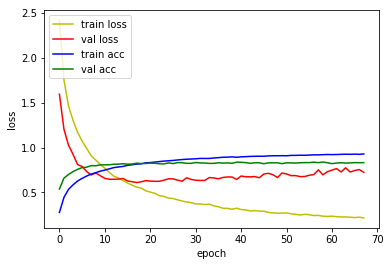

4815/4815 [==============================] - 1s 279us/sample - loss: 0.9128 - acc: 0.7994
Loss: 0.9128006518939327 Accuracy: 0.79937696
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.5469 - acc: 0.5464
Epoch 00001: val_loss improved from inf to 0.77343, saving model to model/checkpoint/2D_CNN_BN_2_conv_1_fcn_checkpoint/01-0.7734.hdf5
36805/36805 [==============================] - 29s 797us/sample - loss: 1.5468 - acc: 0.5464 - val_loss: 0.7734 - val_acc: 0.7706
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.7622 - acc: 0.7629
Epoch 00002: val_loss improved from 0.77343 to 0.50993, saving model to model/checkpoint/2D_CNN_BN_2_conv_1_fcn_checkpoint/02-0.5099.hdf5
36805/36805 [==============================] - 27s 738us/sample - loss: 0.7622 - acc: 0.7628 - val_loss: 0.5099 - val_acc: 0.8505
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.4751 - acc: 0.

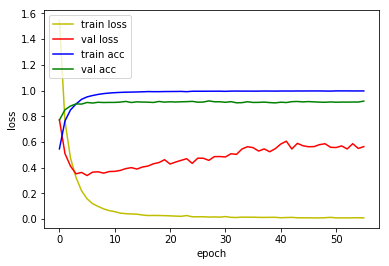

4815/4815 [==============================] - 1s 281us/sample - loss: 0.7771 - acc: 0.8827
Loss: 0.7771099491097103 Accuracy: 0.88265836
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.2946 - acc: 0.3759
Epoch 00001: val_loss improved from inf to 1.20905, saving model to model/checkpoint/2D_CNN_BN_2_conv_2_fcn_checkpoint/01-1.2091.hdf5
36805/36805 [==============================] - 30s 821us/sample - loss: 2.2946 - acc: 0.3759 - val_loss: 1.2091 - val_acc: 0.6664
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.4003 - acc: 0.5819
Epoch 00002: val_loss improved from 1.20905 to 0.79948, saving model to model/checkpoint/2D_CNN_BN_2_conv_2_fcn_checkpoint/02-0.7995.hdf5
36805/36805 [==============================] - 27s 727us/sample - loss: 1.4002 - acc: 0.5820 - val_loss: 0.7995 - val_acc: 0.7813
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9969 - acc: 0.

Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9860
Epoch 00027: val_loss did not improve from 0.31154
36805/36805 [==============================] - 27s 728us/sample - loss: 0.0487 - acc: 0.9860 - val_loss: 0.3613 - val_acc: 0.9259
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0447 - acc: 0.9865
Epoch 00028: val_loss did not improve from 0.31154
36805/36805 [==============================] - 27s 728us/sample - loss: 0.0447 - acc: 0.9865 - val_loss: 0.4139 - val_acc: 0.9178
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0492 - acc: 0.9854
Epoch 00029: val_loss did not improve from 0.31154
36805/36805 [==============================] - 27s 727us/sample - loss: 0.0492 - acc: 0.9854 - val_loss: 0.3985 - val_acc: 0.9187
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0475 - acc: 0.9865
Epoch 00030: val_loss did not improve from 0.31154
36805/36805 [=====

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9939
Epoch 00057: val_loss did not improve from 0.31154
36805/36805 [==============================] - 27s 726us/sample - loss: 0.0235 - acc: 0.9939 - val_loss: 0.4298 - val_acc: 0.9231
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9936
Epoch 00058: val_loss did not improve from 0.31154
36805/36805 [==============================] - 27s 725us/sample - loss: 0.0230 - acc: 0.9936 - val_loss: 0.4441 - val_acc: 0.9259
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0238 - acc: 0.9930
Epoch 00059: val_loss did not improve from 0.31154
36805/36805 [==============================] - 27s 728us/sample - loss: 0.0238 - acc: 0.9930 - val_loss: 0.4639 - val_acc: 0.9255
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9945
Epoch 00060: val_loss did not improve from 0.31154
36805/36805 [=====

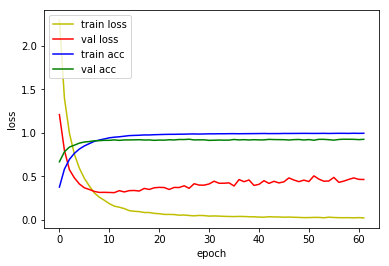

4815/4815 [==============================] - 1s 295us/sample - loss: 0.5913 - acc: 0.8949
Loss: 0.5913128895334985 Accuracy: 0.8949117
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.4474 - acc: 0.5676
Epoch 00001: val_loss improved from inf to 0.67418, saving model to model/checkpoint/2D_CNN_BN_3_conv_1_fcn_checkpoint/01-0.6742.hdf5
36805/36805 [==============================] - 27s 745us/sample - loss: 1.4473 - acc: 0.5676 - val_loss: 0.6742 - val_acc: 0.8081
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.6657 - acc: 0.7928
Epoch 00002: val_loss improved from 0.67418 to 0.42261, saving model to model/checkpoint/2D_CNN_BN_3_conv_1_fcn_checkpoint/02-0.4226.hdf5
36805/36805 [==============================] - 24s 644us/sample - loss: 0.6657 - acc: 0.7929 - val_loss: 0.4226 - val_acc: 0.8786
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.4228 - acc: 0.8

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9978
Epoch 00057: val_loss did not improve from 0.25232
36805/36805 [==============================] - 24s 644us/sample - loss: 0.0074 - acc: 0.9978 - val_loss: 0.3492 - val_acc: 0.9408
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0064 - acc: 0.9978
Epoch 00058: val_loss did not improve from 0.25232
36805/36805 [==============================] - 24s 644us/sample - loss: 0.0064 - acc: 0.9978 - val_loss: 0.3525 - val_acc: 0.9446
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9976
Epoch 00059: val_loss did not improve from 0.25232
36805/36805 [==============================] - 24s 645us/sample - loss: 0.0084 - acc: 0.9976 - val_loss: 0.3542 - val_acc: 0.9385
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9978
Epoch 00060: val_loss did not improve from 0.25232
36805/36805 [=====

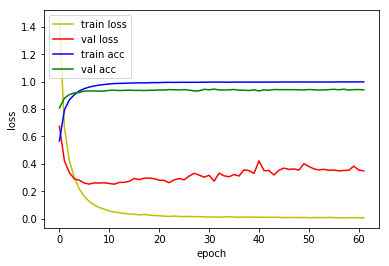

4815/4815 [==============================] - 1s 296us/sample - loss: 0.4204 - acc: 0.9225
Loss: 0.420368439062602 Accuracy: 0.92253375
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.0850 - acc: 0.3814
Epoch 00001: val_loss improved from inf to 1.04404, saving model to model/checkpoint/2D_CNN_BN_3_conv_2_fcn_checkpoint/01-1.0440.hdf5
36805/36805 [==============================] - 29s 787us/sample - loss: 2.0849 - acc: 0.3814 - val_loss: 1.0440 - val_acc: 0.7035
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.1452 - acc: 0.6397
Epoch 00002: val_loss improved from 1.04404 to 0.62654, saving model to model/checkpoint/2D_CNN_BN_3_conv_2_fcn_checkpoint/02-0.6265.hdf5
36805/36805 [==============================] - 24s 662us/sample - loss: 1.1452 - acc: 0.6398 - val_loss: 0.6265 - val_acc: 0.8267
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.7740 - acc: 0.7

Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0429 - acc: 0.9873
Epoch 00027: val_loss did not improve from 0.21623
36805/36805 [==============================] - 24s 664us/sample - loss: 0.0429 - acc: 0.9873 - val_loss: 0.2925 - val_acc: 0.9457
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9896
Epoch 00028: val_loss did not improve from 0.21623
36805/36805 [==============================] - 24s 664us/sample - loss: 0.0340 - acc: 0.9896 - val_loss: 0.2991 - val_acc: 0.9429
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9899
Epoch 00029: val_loss did not improve from 0.21623
36805/36805 [==============================] - 24s 661us/sample - loss: 0.0310 - acc: 0.9899 - val_loss: 0.3024 - val_acc: 0.9432
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9906
Epoch 00030: val_loss did not improve from 0.21623
36805/36805 [=====

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0161 - acc: 0.9951
Epoch 00057: val_loss did not improve from 0.21623
36805/36805 [==============================] - 24s 661us/sample - loss: 0.0161 - acc: 0.9951 - val_loss: 0.3566 - val_acc: 0.9448
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0158 - acc: 0.9954
Epoch 00058: val_loss did not improve from 0.21623
36805/36805 [==============================] - 24s 662us/sample - loss: 0.0158 - acc: 0.9954 - val_loss: 0.3819 - val_acc: 0.9399
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0178 - acc: 0.9950
Epoch 00059: val_loss did not improve from 0.21623
36805/36805 [==============================] - 24s 664us/sample - loss: 0.0178 - acc: 0.9950 - val_loss: 0.3629 - val_acc: 0.9455
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0169 - acc: 0.9957
Epoch 00060: val_loss did not improve from 0.21623
36805/36805 [=====

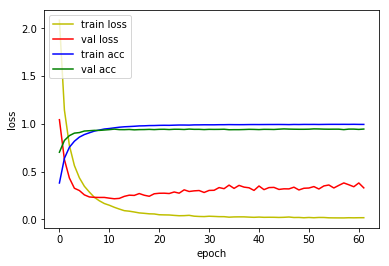

4815/4815 [==============================] - 1s 305us/sample - loss: 0.4609 - acc: 0.9227
Loss: 0.4608793500315704 Accuracy: 0.9227414
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.6282 - acc: 0.5084
Epoch 00001: val_loss improved from inf to 0.82813, saving model to model/checkpoint/2D_CNN_BN_4_conv_1_fcn_checkpoint/01-0.8281.hdf5
36805/36805 [==============================] - 28s 765us/sample - loss: 1.6282 - acc: 0.5084 - val_loss: 0.8281 - val_acc: 0.7545
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.7752 - acc: 0.7560
Epoch 00002: val_loss improved from 0.82813 to 0.47458, saving model to model/checkpoint/2D_CNN_BN_4_conv_1_fcn_checkpoint/02-0.4746.hdf5
36805/36805 [==============================] - 23s 628us/sample - loss: 0.7751 - acc: 0.7560 - val_loss: 0.4746 - val_acc: 0.8605
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.5074 - acc: 0.8

Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9917
Epoch 00027: val_loss did not improve from 0.21321
36805/36805 [==============================] - 23s 629us/sample - loss: 0.0272 - acc: 0.9917 - val_loss: 0.2370 - val_acc: 0.9457
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0189 - acc: 0.9944
Epoch 00028: val_loss did not improve from 0.21321
36805/36805 [==============================] - 23s 628us/sample - loss: 0.0189 - acc: 0.9944 - val_loss: 0.2541 - val_acc: 0.9450
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9941
Epoch 00029: val_loss did not improve from 0.21321
36805/36805 [==============================] - 23s 626us/sample - loss: 0.0210 - acc: 0.9941 - val_loss: 0.2524 - val_acc: 0.9455
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0211 - acc: 0.9932
Epoch 00030: val_loss did not improve from 0.21321
36805/36805 [=====

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0099 - acc: 0.9968
Epoch 00057: val_loss did not improve from 0.21321
36805/36805 [==============================] - 23s 631us/sample - loss: 0.0099 - acc: 0.9968 - val_loss: 0.2963 - val_acc: 0.9455
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9979
Epoch 00058: val_loss did not improve from 0.21321
36805/36805 [==============================] - 23s 627us/sample - loss: 0.0076 - acc: 0.9979 - val_loss: 0.2867 - val_acc: 0.9457
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0101 - acc: 0.9969
Epoch 00059: val_loss did not improve from 0.21321
36805/36805 [==============================] - 23s 628us/sample - loss: 0.0101 - acc: 0.9969 - val_loss: 0.3071 - val_acc: 0.9453
Epoch 60/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0107 - acc: 0.9968
Epoch 00060: val_loss did not improve from 0.21321
36805/36805 [=====

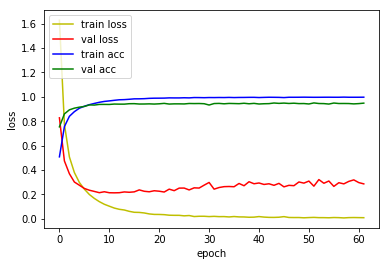

4815/4815 [==============================] - 1s 299us/sample - loss: 0.3975 - acc: 0.9248
Loss: 0.3974968733863667 Accuracy: 0.9248183
Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.1682 - acc: 0.3381
Epoch 00001: val_loss improved from inf to 1.23108, saving model to model/checkpoint/2D_CNN_BN_4_conv_2_fcn_checkpoint/01-1.2311.hdf5
36805/36805 [==============================] - 29s 797us/sample - loss: 2.1682 - acc: 0.3381 - val_loss: 1.2311 - val_acc: 0.6194
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.2402 - acc: 0.6013
Epoch 00002: val_loss improved from 1.23108 to 0.71594, saving model to model/checkpoint/2D_CNN_BN_4_conv_2_fcn_checkpoint/02-0.7159.hdf5
36805/36805 [==============================] - 26s 709us/sample - loss: 1.2401 - acc: 0.6013 - val_loss: 0.7159 - val_acc: 0.7717
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.8504 - acc: 0.7

Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0521 - acc: 0.9836
Epoch 00026: val_loss did not improve from 0.20718
36805/36805 [==============================] - 26s 704us/sample - loss: 0.0521 - acc: 0.9836 - val_loss: 0.2338 - val_acc: 0.9446
Epoch 27/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0482 - acc: 0.9849
Epoch 00027: val_loss did not improve from 0.20718
36805/36805 [==============================] - 26s 701us/sample - loss: 0.0482 - acc: 0.9849 - val_loss: 0.2472 - val_acc: 0.9471
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0451 - acc: 0.9857
Epoch 00028: val_loss did not improve from 0.20718
36805/36805 [==============================] - 26s 706us/sample - loss: 0.0450 - acc: 0.9857 - val_loss: 0.2552 - val_acc: 0.9476
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0427 - acc: 0.9863
Epoch 00029: val_loss did not improve from 0.20718
36805/36805 [=====

Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9936
Epoch 00056: val_loss did not improve from 0.20718
36805/36805 [==============================] - 26s 699us/sample - loss: 0.0236 - acc: 0.9936 - val_loss: 0.3365 - val_acc: 0.9464
Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9935
Epoch 00057: val_loss did not improve from 0.20718
36805/36805 [==============================] - 26s 706us/sample - loss: 0.0218 - acc: 0.9935 - val_loss: 0.2880 - val_acc: 0.9481
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9930
Epoch 00058: val_loss did not improve from 0.20718
36805/36805 [==============================] - 26s 706us/sample - loss: 0.0227 - acc: 0.9930 - val_loss: 0.3093 - val_acc: 0.9478
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0193 - acc: 0.9939
Epoch 00059: val_loss did not improve from 0.20718
36805/36805 [=====

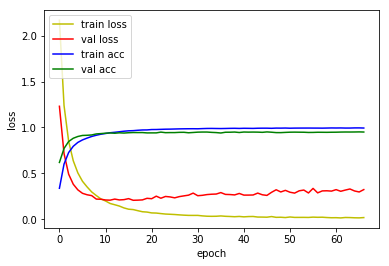

4815/4815 [==============================] - 2s 313us/sample - loss: 0.4604 - acc: 0.9271
Loss: 0.4603858264047084 Accuracy: 0.9271028


In [48]:
for i in range(1, 5):
    for j in range(1, 3):
        model = build_bn_cnn(conv_num=i, fcn_num=j)
#         model.summary()
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])
    
        model_path = 'model/checkpoint/2D_CNN_BN_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        os.makedirs(model_path, exist_ok=True)
        model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
        checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                       verbose=1, save_best_only=True)

        early_stopping = EarlyStopping(monitor='val_loss', patience=50)
        hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=200, 
                         validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                         callbacks = [checkpointer, early_stopping])

        print()
        print('{} Conv {} FCN Model'.format(i, j))
        fig, ax = plt.subplots()
        ax.plot(hist.history['loss'], 'y', label='train loss')
        ax.plot(hist.history['val_loss'], 'r', label='val loss')
        ax.plot(hist.history['acc'], 'b', label='train acc')
        ax.plot(hist.history['val_acc'], 'g', label='val acc')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        plt.show()
        
        png_path = 'visualization/learning_curve/'
        filename = '2D_CNN_BN_{}_conv_{}_fcn'.format(i, j)+'.png'
        os.makedirs(png_path, exist_ok=True)
        fig.savefig(png_path+filename, transparent=True)
        
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
        model = load_model(model_filename)
        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

In [11]:
for i in range(1, 5):
    for j in range(1, 3):
        model_name = '2D_CNN_BN_{}_conv_{}_fcn'.format(i, j)
        print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'
  
        model = load_model(model_filename)
        model.summary()
    
        [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

2D_CNN_BN_1_conv_1_fcn Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 253, 95, 8)        208       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 253, 95, 8)        32        
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 127, 48, 8)        0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 48768)             0         
_________________________________________________________________
dense_104 (Dense)            (None, 1024)              49939456  
_________________________________________________________________
dropout_62 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_105 (Dense)            (None, 16)        

4815/4815 [==============================] - 2s 324us/sample - loss: 0.3470 - acc: 0.9144
Loss: 0.3470151731498764 Accuracy: 0.9144341

2D_CNN_BN_3_conv_2_fcn Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 253, 95, 8)        208       
_________________________________________________________________
batch_normalization_v1_9 (Ba (None, 253, 95, 8)        32        
_________________________________________________________________
max_pooling2d_119 (MaxPoolin (None, 127, 48, 8)        0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 123, 44, 16)       3216      
_________________________________________________________________
batch_normalization_v1_10 (B (None, 123, 44, 16)       64        
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 62, 22,